In [1]:
import numpy as np
import shutil
import re
import math
import numpy
import pandas as pd
import csv
import math
import string
import sys
import fileinput
import json
import urllib
import urllib3
import requests
import zipfile
import time
import argparse
import pickle
from termcolor import colored, cprint
import colorama
import webbrowser
import base64
from sklearn.externals import joblib
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils import shuffle
import sklearn.ensemble as ske
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_predict, learning_curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import SafeBrowse

In [2]:
def get_learning_curve(X, y):
    clf=ske.RandomForestClassifier(n_estimators=50)
    parameter_grid = np.array([200, 500, 800, 1100])
    train_size, train_scores, validation_scores = learning_curve(clf, X, y, train_sizes=parameter_grid, cv=5)


    # plot the data
    plt.figure(figsize=(10, 8), dpi=80)
    plt.plot(parameter_grid, 100 * np.average(train_scores, axis=1), color='black')
    plt.title('Learning curve')
    plt.xlabel('Number of training samples')
    plt.ylabel('Accuracy')
    plt.show()

In [3]:
def plot_confusion_matrix(cm, labels_name, title):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]    # Normalize
    plt.imshow(cm, interpolation='nearest')    # Display images on specific windows
    plt.title(title)    # Title of the image
    plt.colorbar()
    num_local = np.array(range(len(labels_name)))
    plt.xticks(num_local, labels_name, rotation=90)    # 将标签印在x轴坐标上
    plt.yticks(num_local, labels_name)    # 将标签印在y轴坐标上
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [4]:
def plot_ROC_CURVE(y,Y):
    # plot ROC curve
    fpr, tpr, threshold = roc_curve(y, Y)  ###Calculate TPR and FPR
    roc_auc = auc(fpr, tpr)  ###calculate ROC

    plt.figure()
    lw = 2
    plt.figure(figsize=(10, 10))
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)  ###FPR as x，TPR as y
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [8]:
def train_model():
    # Creates a pandas dataframe and reads in the URL dataset with
    # extracted features. 
    df = pd.read_csv('data_urls.csv', sep='|')

    # Assigns X to features. Drops URL name and label.
    X = df.drop(['URL', 'Malicious'], axis=1).values
    
    # Assigns y to labels.
    y = df['Malicious'].values

    # Split data into training and test datasets.
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42) 

    # Print the number of training and testing samples.
    print("\t Training samples: ", len(X_train))
    print("\t Testing samples: ", len(X_test))
    
    ##Standardize
    s = StandardScaler()
    X_train_scale = s.fit_transform(X_train)
    X_test_scale = s.transform(X_test)

    # Train Random forest algorithm on training dataset.
    clf = ske.RandomForestClassifier(n_estimators=50)   
    clf.fit(X_train, y_train)
   
    # Perform cross validation and print out accuracy.
    score = model_selection.cross_val_score(clf, X_test, y_test, cv=10)
    print("\n\t Cross Validation Score: ", round(score.mean()*100, 2), '%')
    
    
    # Calculate f1 score.
    y_train_pred = cross_val_predict(clf, X_train, y_train, cv=3)
    f = f1_score(y_train, y_train_pred)
    print("\t F1 Score: ", round(f*100, 2), '%')
   
    
    
    plot_ROC_CURVE(y_train, y_train_pred)

    # plot the matrix

    cm=confusion_matrix(y_train,y_train_pred)
    plot_confusion_matrix(cm,["malicious","benign"],"Confusion Matrix")
    plt.show()

    # plot learning curve
    get_learning_curve(X_train,y_train)
    # Save the configuration of the classifier and features as a pickle file.
    
    all_features = X.shape[1]
    features = []

    for feature in range(all_features):
        features.append(df.columns[1+feature])

    try:
        print("\n Saving algorithm and feature list in classifier directory...")
        joblib.dump(clf, 'classifier.pkl')
        open('features.pkl', 'wb').write(pickle.dumps(features))
        print(colored('\n[*] ', 'green') + " Saved.")
    except:
        print('\n Error: Algorithm and feature list not saved correctly.\n')
    

	 Training samples:  8000
	 Testing samples:  2000

	 Cross Validation Score:  92.6 %
	 F1 Score:  92.72 %


<Figure size 432x288 with 0 Axes>

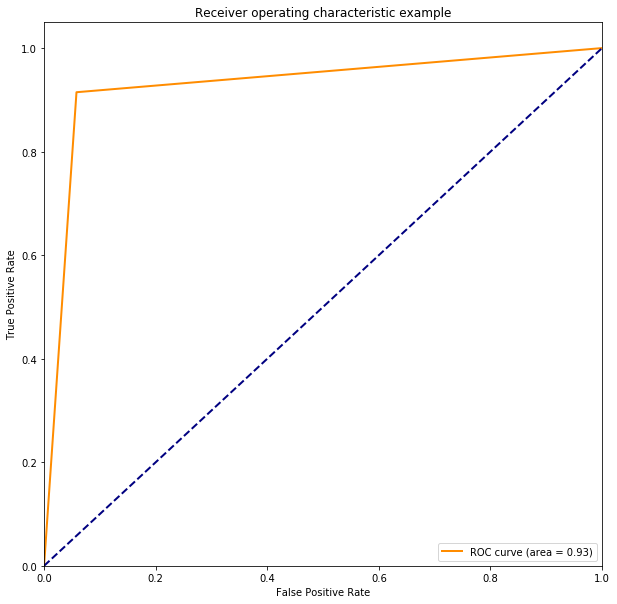

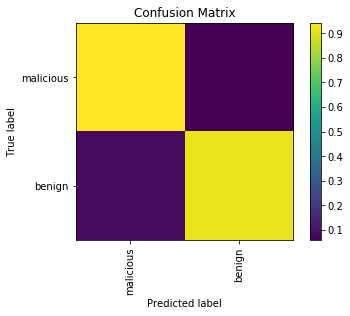

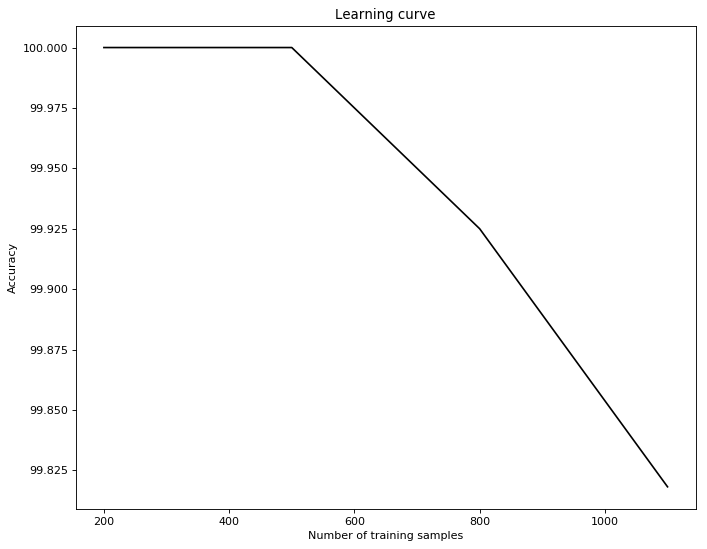


 Saving algorithm and feature list in classifier directory...

[*]  Saved.


In [9]:
train_model()

In [ ]:
# Get URL information function extracts features from a user supplied
# URL. The function extracts all features similarly to extract_features()
# but instead saves the extracted features in the form of a dictionary. 
def get_url_info(url):
    # Creates a dictionary for features to be stored in.
    features = {}
    
    # Parses input URL to remove http:// or https://.
    # The umbrella dataset does not contain this and thus,
    # is not required for certain feature extractions.
    parsed_url = parse_url(url)

    # Retrieve URL entropy and store in dictionary.
    getentropy = URLFeatures(parsed_url)
    entropy = getentropy.Entropy()
    features['Entropy'] = entropy

    feature = URLFeatures()

    # Store Bag Of Words in dictionary.  
    features['BagOfWords'] = feature.bag_of_words(parsed_url)
    
    # Store Contains IP address in dictionary.
    features['ContainsIP'] = feature.contains_IP(parsed_url)

    # Store URL length in dictionary.
    features['LengthURL'] = feature.url_length(parsed_url)

    # Store amount of special characters in dictionary.
    features['SpecialChars'] = feature.special_chars(parsed_url)

    # Store amount of suspicious strings in dictionary.
    features['SuspiciousStrings'] = feature.suspicious_strings(url)

    # Store number of digits within the URL in dictionary.
    features['NumberOfDigits'] = feature.num_digits(parsed_url)

    # Store site popularity in dictionary.
    features['Popularity'] = feature.popularity(parsed_url)

    # Store Google Safebrowsing verdict in dictionary.
    apikey = base64.b64decode('QUl6YVN5QV9XbU53MHRyZTEybWtMOE1qYUExY0c3Smd4SnRuU0lv')
    apikey = apikey.decode('utf-8')
    safe = SafeBrowse(apikey)
    features['Safebrowsing'] = safe.threat_matches_find(url) 

    # Return features dictionary.
    return features

In [ ]:
# Classify URL function passes in the input URL and classifies
# it as malicious or benign. 
def classify_url(url):

    # Loads classifier and feature configurations.
    clf = joblib.load(os.path.join(
    os.path.dirname(os.path.realpath(__file__)),
    'classifier.pkl'))

    features = pickle.loads(open(os.path.join(
        os.path.dirname(os.path.realpath(__file__)),
        'features.pkl'),
        'rb').read())
    
    # Extracts features from input URL.
    data = get_url_info(url)
    feature_list = list(map(lambda x:data[x], features))

    # Classifies input URL as malicious or benign.
    result = clf.predict([feature_list])[0]

    if result == 0:
        print("MLURL has classified URL %s as " % url + colored("benign", 'green') + '.')
    else: 
        print("MLURL has classified URL %s as " % url + colored("malicious", 'red') + '.')
    
    return result

In [ ]:
# Check valid URL function checks whether or not the input
# URL to classify is in a valid format.

def check_valid_url(url):
    print("\n[+] Validating URL format...")
    reg = re.compile('^(http:\/\/www\.|https:\/\/www\.|http:\/\/|https:\/\/)?[a-z0-9]+([\-\.]{1}[a-z0-9]+)*\.[a-z]{2,5}(:[0-9]{1,5})?(\/.*)?$')
    
    if re.match(reg, str(url)):
        print("URL is valid.")
    else:
        print("Error: URL is not valid. Please input a valid URL format. ")
        sys.exit(0)